**This notebook pertains to a course project done for a Big Data Analytics course**

The main research questions that this project attempts to answer are: 


- Can we use basic features of listings available in housing portals to predict prices of apartments in Stockholm with a high degree of accuracy (> 95%) using common ML techniques?


- Can we use AirBnB listings of Stockholm to predict neighbourhood clusters to a high degree of accuracy (>95%) that could in turn help predict prices for apartments?

Additionally, we wanted to explore how these basic datasets could help provide the public buyer (or seller) to discover important features to consider.


Our main data sources are:
 - InsideAirBnB
 - Hemnet listings


In [34]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import time

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# For neater tables
from IPython.display import display, HTML

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## DATA COLLECTION

For __AirBnB data__, we used the open dataset available at the [InsideAirBnb](http://insideairbnb.com) website

 - [Listings Data](http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2022-09-24/data/listings.csv.gz)

 - [Neighbourhood Data](http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2022-09-24/visualisations/neighbourhoods.csv)

For __Stockholm's housing data__:
We created a [fork](https://github.com/aeganskies/HemKop-SV)
of the public Github repo from [Gustaf Halvardsson](https://github.com/gustafvh/Apartment-ML-Predictor-Stockholm_-with-WebScraper-and-Data-Insights) to scrape real estate listings from [Hemnet](www.hemnet.se) since the original repository was broken (older than 3 years) and was not updated with changes made to Hemnet's website and changes in the selenium package. Further, we added additional code to save the scraped data temporarily in the case of system crashes or network outages (since total scraping time was more than 90 hours, this was not a trivial concern and happened on multiple occasions for us). The biggest changes were made mostly in the Webscraper component, besides some refactoring of the remainder of the code to preprocess the data before geocoding the location of the apartment listings.

In [ ]:
%run main.py #DO NOT RUN THIS ON A WHIM! -> takes 90+ hours to scrape the data!!


## DATA PRE-PROCESSING

We first inspect the raw data file to check that everything is as expected and to understand what kind of preprocessing might be necessary.

In [4]:
# Load the raw csv file
df = pd.read_csv('./Data/RawDataFile.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51463 entries, 0 to 51462
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    51463 non-null  int64  
 1   Adress  51463 non-null  object 
 2   Size    50193 non-null  float64
 3   Rooms   51463 non-null  int64  
 4   Broker  51463 non-null  object 
 5   Rent    51463 non-null  int64  
 6   Price   51463 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 2.7+ MB


,Date,Adress,Size,Rooms,Broker,Rent,Price
0,20220329,Adolfsbergsvägen 12,20.0,1,Malou\nMaxe,1906,1875000
1,20220329,Adolfsbergsvägen 12,20.0,1,Mathias\nOdehag,1906,1850000
2,20210811,Adolfsbergsvägen 12,20.0,1,Gabriel\nYouhanoun,1588,1715000
3,20200818,Adolfsbergsvägen 12,20.0,1,Hevrê\nYildiz,1588,1850000
4,20200228,Adolfsbergsvägen 12,20.0,1,Caroline\nHanell,1588,1948000


We can see that the dataset has over 50000 entries, but also contains duplicates. Also, the broker names are not correcly stored and some of the columns can be converted to integer format for better data processing without any loss of information. We also want to add a new Datetime column which will allow us to use the Pandas datetime functions. Finally, since the price of an apartment differs according to size, a combined data type that normalizes this aspect can be useful and so we add a price/meter<sup>2</sup> column and save this pre-processed file.


In [6]:
################
# PRE-PROCESSING
################

# convert datatypes to integer
df['Date'] = df['Date'].astype(np.int64)
df['Rooms'] = df['Rooms'].astype(np.int64)
df['Rent'] = df['Rent'].astype(np.int64)
df['Price'] = df['Price'].astype(np.int64)

# clean up broker/realtor names (remove the '\n')
df.Broker = [broker.replace('\n', ' ') for broker in df.Broker]

# Drop Rows with NaN Values inplace
df.dropna(inplace=True)

# Save Cleaned data

df.to_csv('./Data/CleanDataFile.csv', index=False)

In [12]:
df = pd.read_csv('./Data/CleanDataFile.csv')

# create new Datetime column
df['Datetime'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

# Add Price/square meter column (PricePerKvm)
df['PricePerKvm'] = 0.0

for i in range(0, len(df)):
        df.at[i, 'PricePerKvm'] = round(df.at[i, 'Price'] / df.at[i, 'Size'], 0)

df['PricePerKvm'] = df['PricePerKvm'].astype('float')

# sort by adress & date, remove duplicates
df.sort_values(by=['Adress','Datetime'], ascending=True)
df.drop_duplicates(subset=['Adress'], keep='last', inplace=True)

# Save Cleaned data
df.to_csv('./Data/CleanDataFile.csv', index=False)

We now add 3 columns - nearbyPOIs, Latitude & Longitude to give us precise geo-coordinates of the locations and also an idea about the number of restaurants, pubs, schools etc that are nearby (within a 2 KM radius). We do this via **Yelp's** [API](https://www.yelp.com/developers/v3/manage_app). Note that this step requires an API developer key. 

In [ ]:
# Add Geocoding -> this is rate limited to 5000 API calls per day.
# Enter your own API key in a config.py file in the same directory as this notebook in the following format
# yelp_api_key = "MY_SECRET_KEY"

from YelpApi import updateDfWithYelpDetails #This is part of the python files in the home directory of the repository

# Read CSV and add Geocoding via Yelp API
df = pd.read_csv('/Data/CleanDataFile.csv')
df = updateDfWithYelpDetails(df, 0, len(df)) #You will have to change the to_rows & from_row numbers for each time you cross your API limit
df.to_csv('./Data/UpdatedDataFile.csv', mode='a', index=False) #The filename is kept separate to prevent overwriting

## DATA EXPLORATION & ANALYSIS

We now have a more complete and useful dataset. Once again, we quickly inspect the file & get some information on the entries. We then plot some histograms to get a sense of the range and means of the data and also use violin plots to check the nature of the distribution of Prices and Rents. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16700 entries, 0 to 16699
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         16700 non-null  int64  
 1   Adress       16700 non-null  object 
 2   Size         16700 non-null  float64
 3   Rooms        16700 non-null  int64  
 4   Broker       16700 non-null  object 
 5   Rent         16700 non-null  int64  
 6   Price        16700 non-null  int64  
 7   Datetime     16700 non-null  object 
 8   PricePerKvm  16700 non-null  int64  
 9   NearbyPOIs   16700 non-null  int64  
 10  Latitude     16700 non-null  float64
 11  Longitude    16700 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 1.5+ MB


,Date,Size,Rooms,Rent,Price,PricePerKvm,NearbyPOIs,Latitude,Longitude
count,1.670000e+04,16700.000000,16700.000000,16700.000000,1.670000e+04,16700.000000,16700.000000,16700.000000,16700.000000
mean,1.509223e+07,71.909760,2.781198,3711.237545,5.457818e+06,77109.694132,377.301257,59.320166,18.025101
std,8.180504e+06,29.737165,1.174425,1491.336229,3.447318e+06,31176.741532,443.001313,0.033922,0.066755
min,2.013023e+06,20.000000,1.000000,29.000000,7.690000e+05,9047.000000,4.000000,59.231784,17.803345
25%,2.022114e+06,48.000000,2.000000,2601.750000,2.970000e+06,53173.000000,37.000000,59.297057,17.988739
50%,2.021092e+07,69.000000,3.000000,3591.000000,4.250000e+06,74223.000000,128.000000,59.318787,18.038864
75%,2.022061e+07,95.000000,4.000000,4708.000000,7.050000e+06,100000.000000,621.000000,59.341553,18.076630
max,2.022123e+07,150.000000,8.000000,11192.000000,4.500000e+07,302013.000000,1900.000000,59.417796,18.162460


array([[<AxesSubplot: title={'center': 'Date'}>,
        <AxesSubplot: title={'center': 'Size'}>,
        <AxesSubplot: title={'center': 'Rooms'}>],
       [<AxesSubplot: title={'center': 'Rent'}>,
        <AxesSubplot: title={'center': 'Price'}>,
        <AxesSubplot: title={'center': 'PricePerKvm'}>],
       [<AxesSubplot: title={'center': 'NearbyPOIs'}>,
        <AxesSubplot: title={'center': 'Latitude'}>,
        <AxesSubplot: title={'center': 'Longitude'}>]], dtype=object)

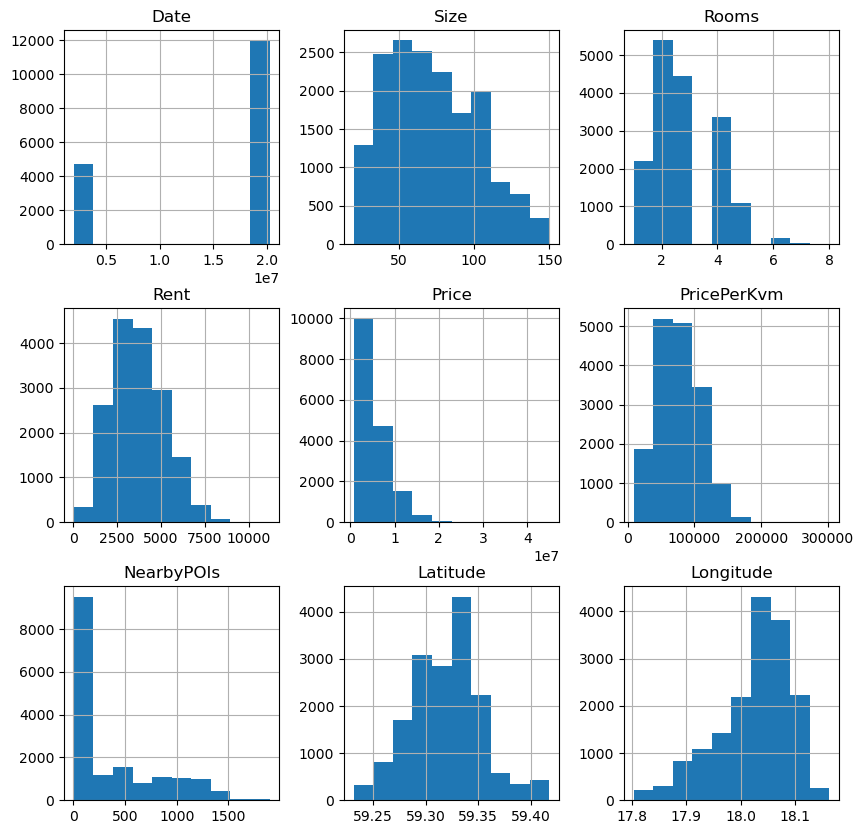

In [8]:
#############################
# DATA EXPLORATION & ANALYSIS
#############################
# The filename below is an already geotagged file. If you run from scratch, change the filename in the previous cell
df = pd.read_csv('./Data/UpdatedDataFile.csv')

df.info()
display(HTML(df.describe().to_html()))

# Check histogram
df.hist(figsize=(10,10))

<AxesSubplot: xlabel='Price'>

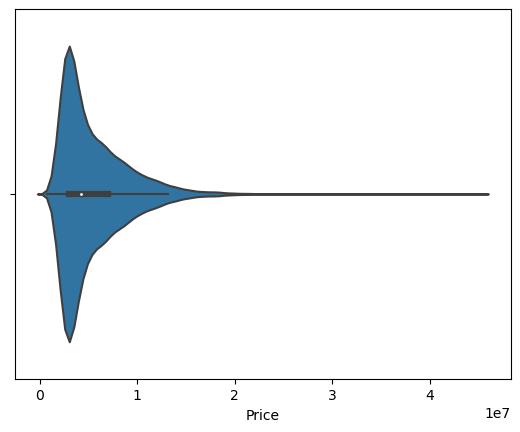

In [11]:
# Check density & distribution via violin plot
sb.violinplot(data=df, x='Price')

<AxesSubplot: xlabel='Rent'>

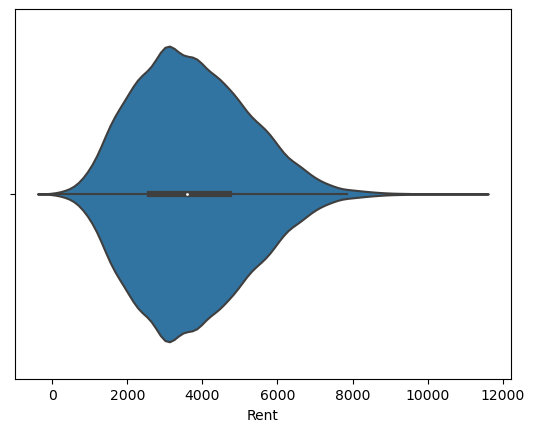

In [10]:
sb.violinplot(data=df, x='Rent')

/tmp/ipykernel_500867/3876449790.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[columns[k]], ax = ax1[i][j], color = 'blue')
/tmp/ipykernel_500867/3876449790.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[columns[k]], ax = ax1[i][j], color = 'blue')
/tmp/ipykernel_500867/38764497

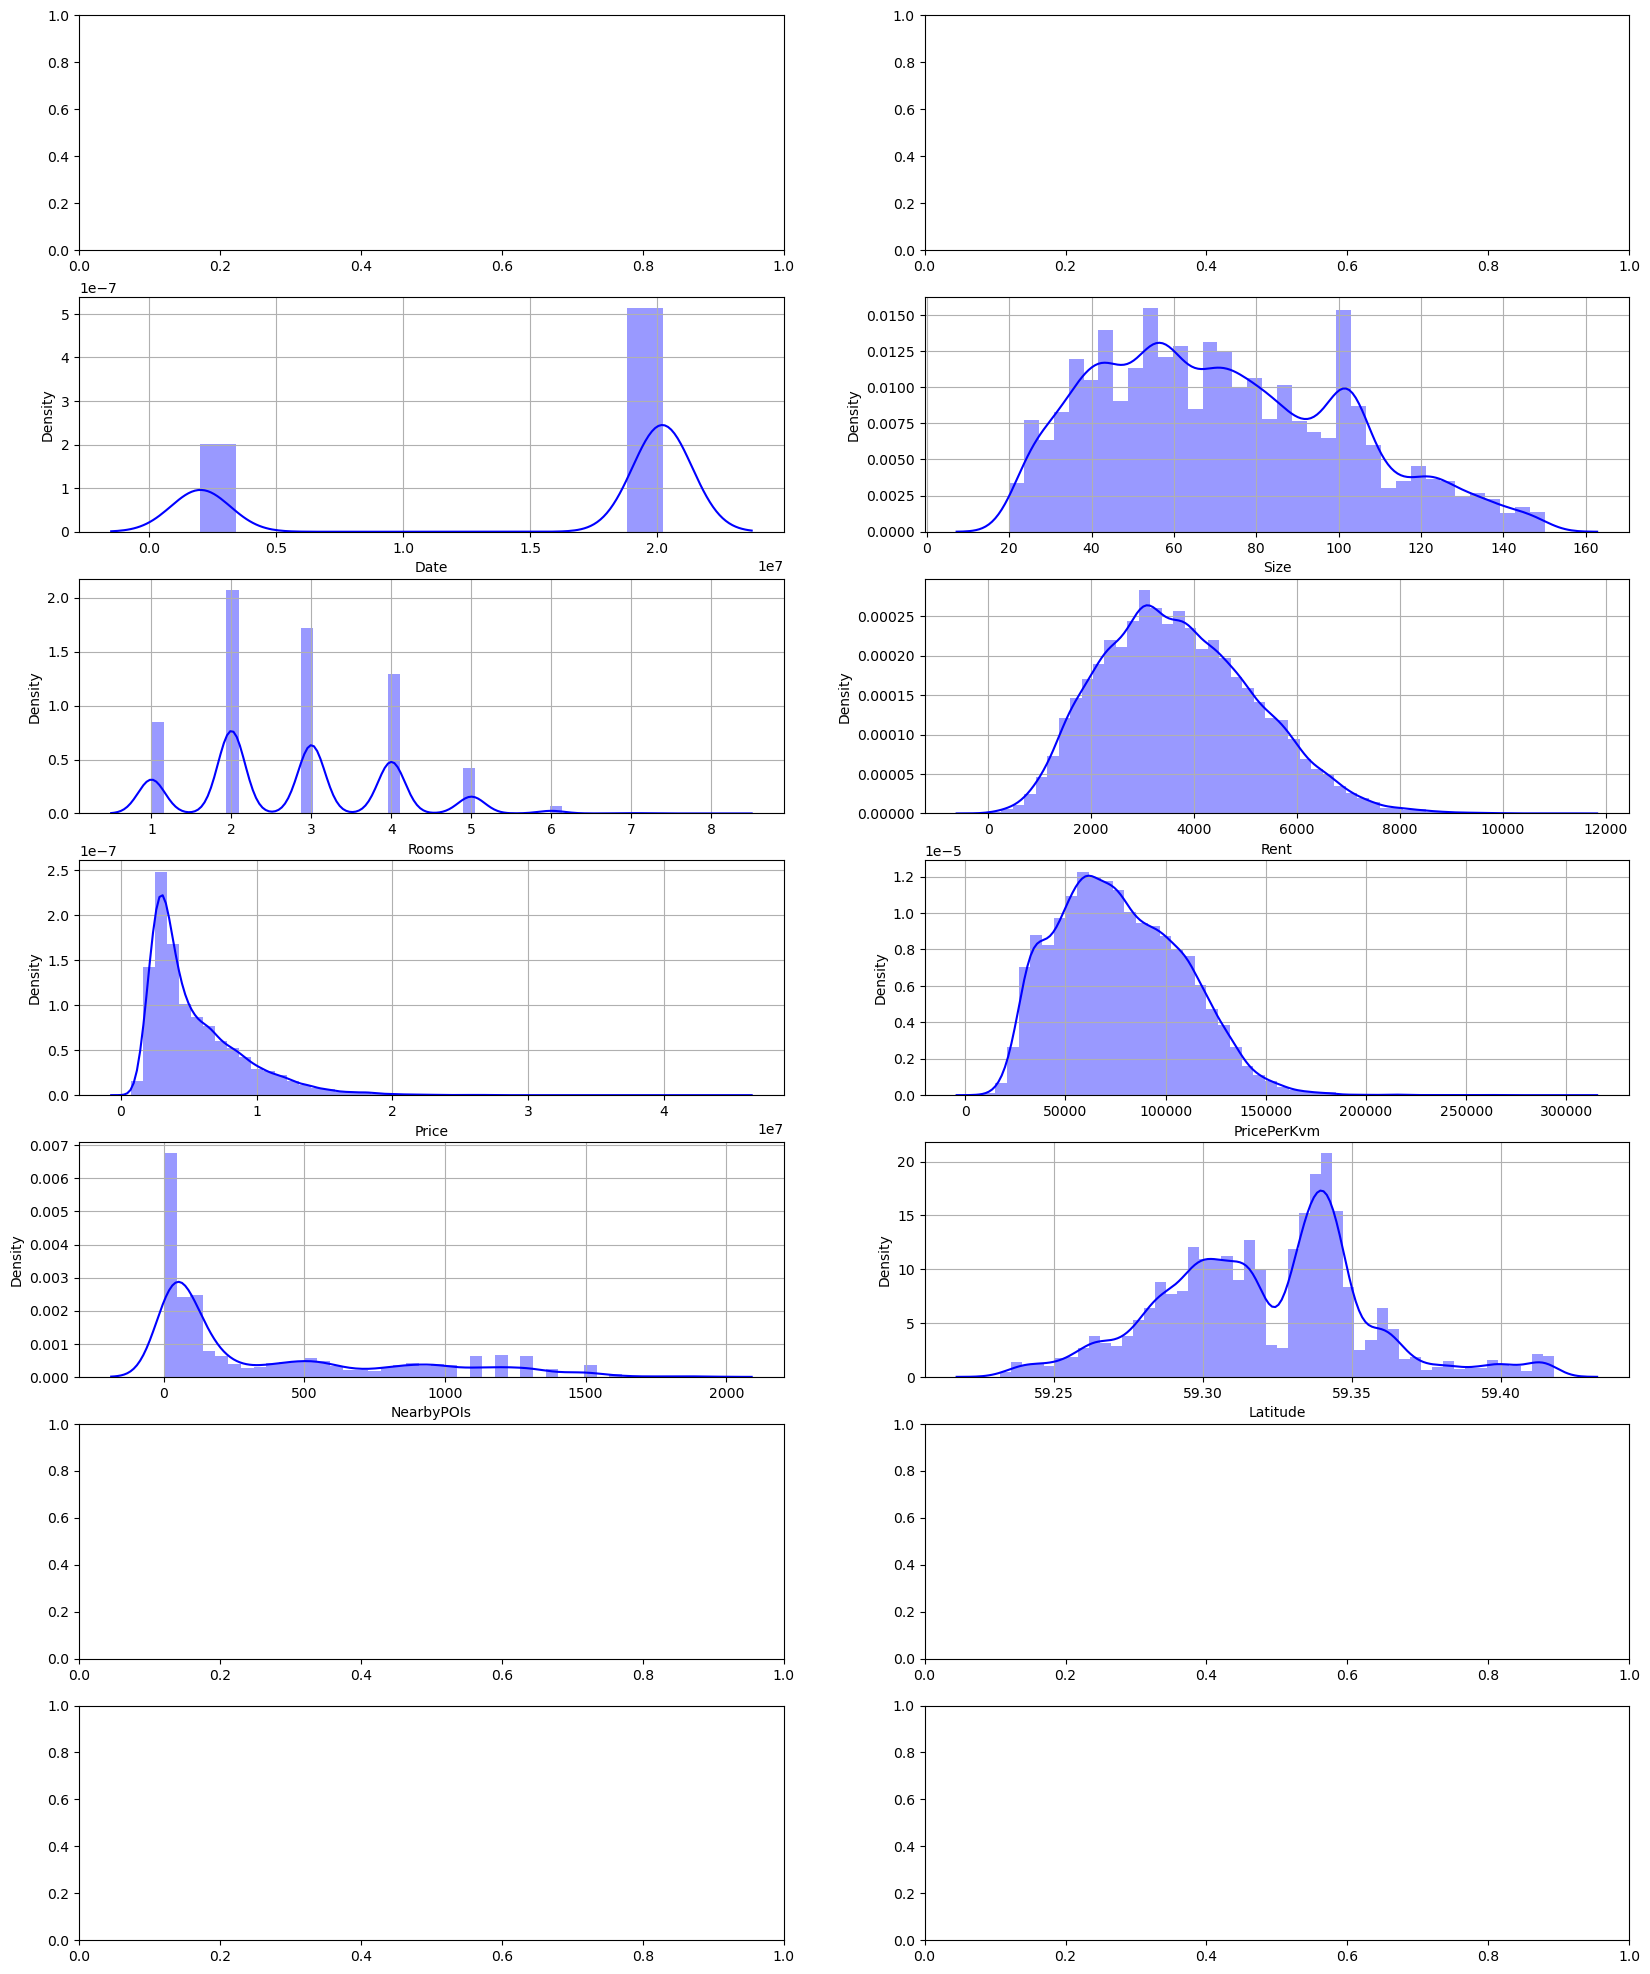

In [14]:
#############################
# DATA EXPLORATION & ANALYSIS
#############################

# Check frequency/distribution plots
# Remove object cols
dist_df = df.drop(columns=["Date", "Adress", "Broker", "Datetime"])
fig, ax1 = plt.subplots(7,2, figsize=(20,25))
k = 0
columns = list(dist_df.columns)
for i in range(1,5,1):
    for j in range(2):
            sb.distplot(df[columns[k]], ax = ax1[i][j], color = 'blue')
            ax1[i][j].grid(True)
            k += 1
plt.show()

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

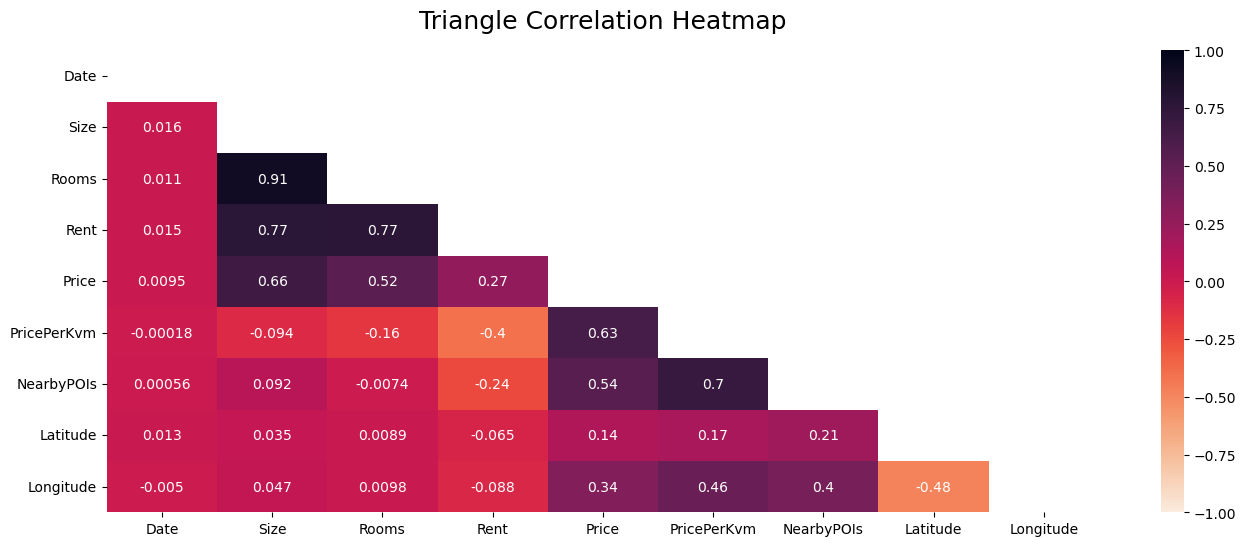

In [15]:
#############################
# DATA EXPLORATION & ANALYSIS
#############################

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=object))
heatmap = sb.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='rocket_r')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)


From the above heatmap, we can infer that:

The price/meter<sup>2</sup> is highly correlated to the number of Points of Interest (POIs). This means that the apartments which have more nearby restaurants, pubs, schools etc are priced much more.

Also, the same is more than twice as dependent on Longitude than Latitude. This means that apartments in East or West Stockholm are more likely to be expensive compared to those in North & South Stockholm. From the map of Stockholm below, this is more clearer where we can see that the northern boundary of the city is rather elongated.

Text(0.5, 1.0, 'Prices in Stockholm')

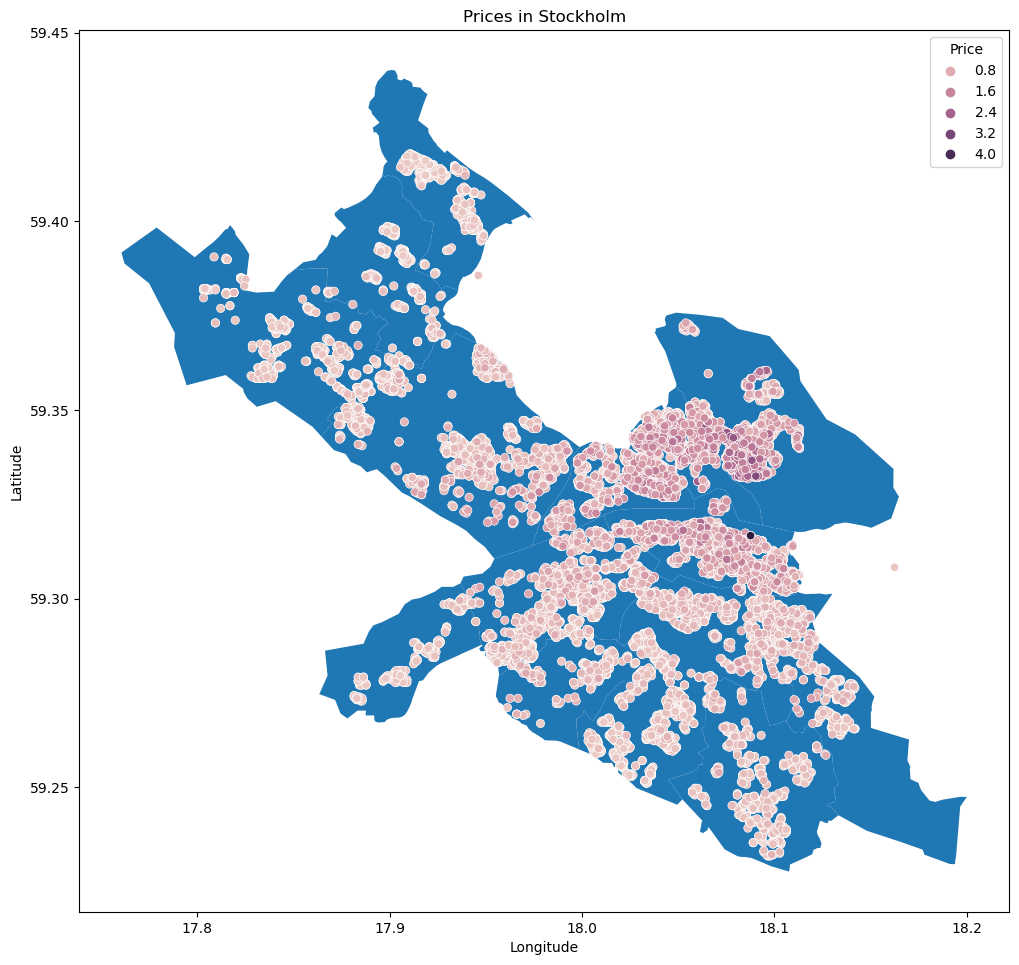

In [18]:
# Visualize the data over Stockholm
import geopandas as gpd

# Sort table to allow higher prices to be displayed clearly 
df.sort_values(by=['Price'], ascending=True)
# Create a GeoDataFrame from the data points
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]))

# Load a map of Stockholm
city = gpd.read_file("./Data/neighbourhoods.geojson")

# Plot the map and the data points using Seaborn
sb.scatterplot(x="Longitude", y="Latitude", hue="Price", data=gdf, legend="auto", ax=city.plot(figsize=(12, 12)))
plt.title("Prices in Stockholm")

We now check the features that correlates the most with the price via a heatmap. Similar to what we saw in the triangle heatmap, it is clear which columns have the most association with price.

Text(0.5, 1.0, 'Features Correlating with Price')

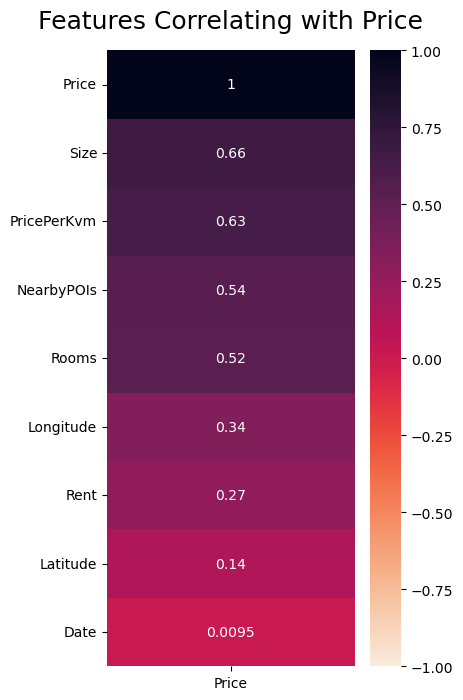

In [19]:
#############################
# DATA EXPLORATION & ANALYSIS
#############################

plt.figure(figsize=(4, 8))
heatmap = sb.heatmap(df.corr()[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='rocket_r')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16)

We confirm this via another plot which should make it very obvious.

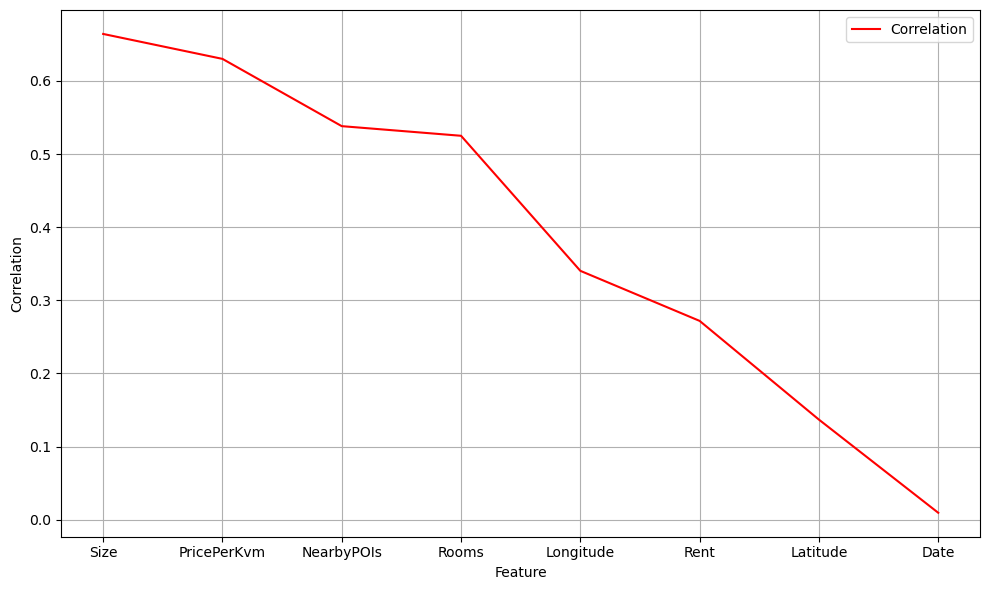

In [22]:
#############################
# DATA EXPLORATION & ANALYSIS
#############################
corr=abs(df.corr())
plt.figure(figsize=(10,6))
plt.plot(corr["Price"].sort_values(ascending=False)[1:],label="Correlation",color="red")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

We can see from the above plots of features correlating with Price, that the most important features are PricePerKvm (kind of obvious), but more interestingly, size, Nearby POIs and Rooms, with Longitude to a certain degree. Another thing to note is that Rent has very little correlation to the Price. This means that there are other factors more important for rental prices.

We now have a good idea of the features that we train our models on.
However, there is one crucial aspect - since we are going to use regression models, it is important that the training data is not skewed too heavily by outliers. To do this, we first get some box plots and remove outliers lying outside 80% of the quantile of the data.

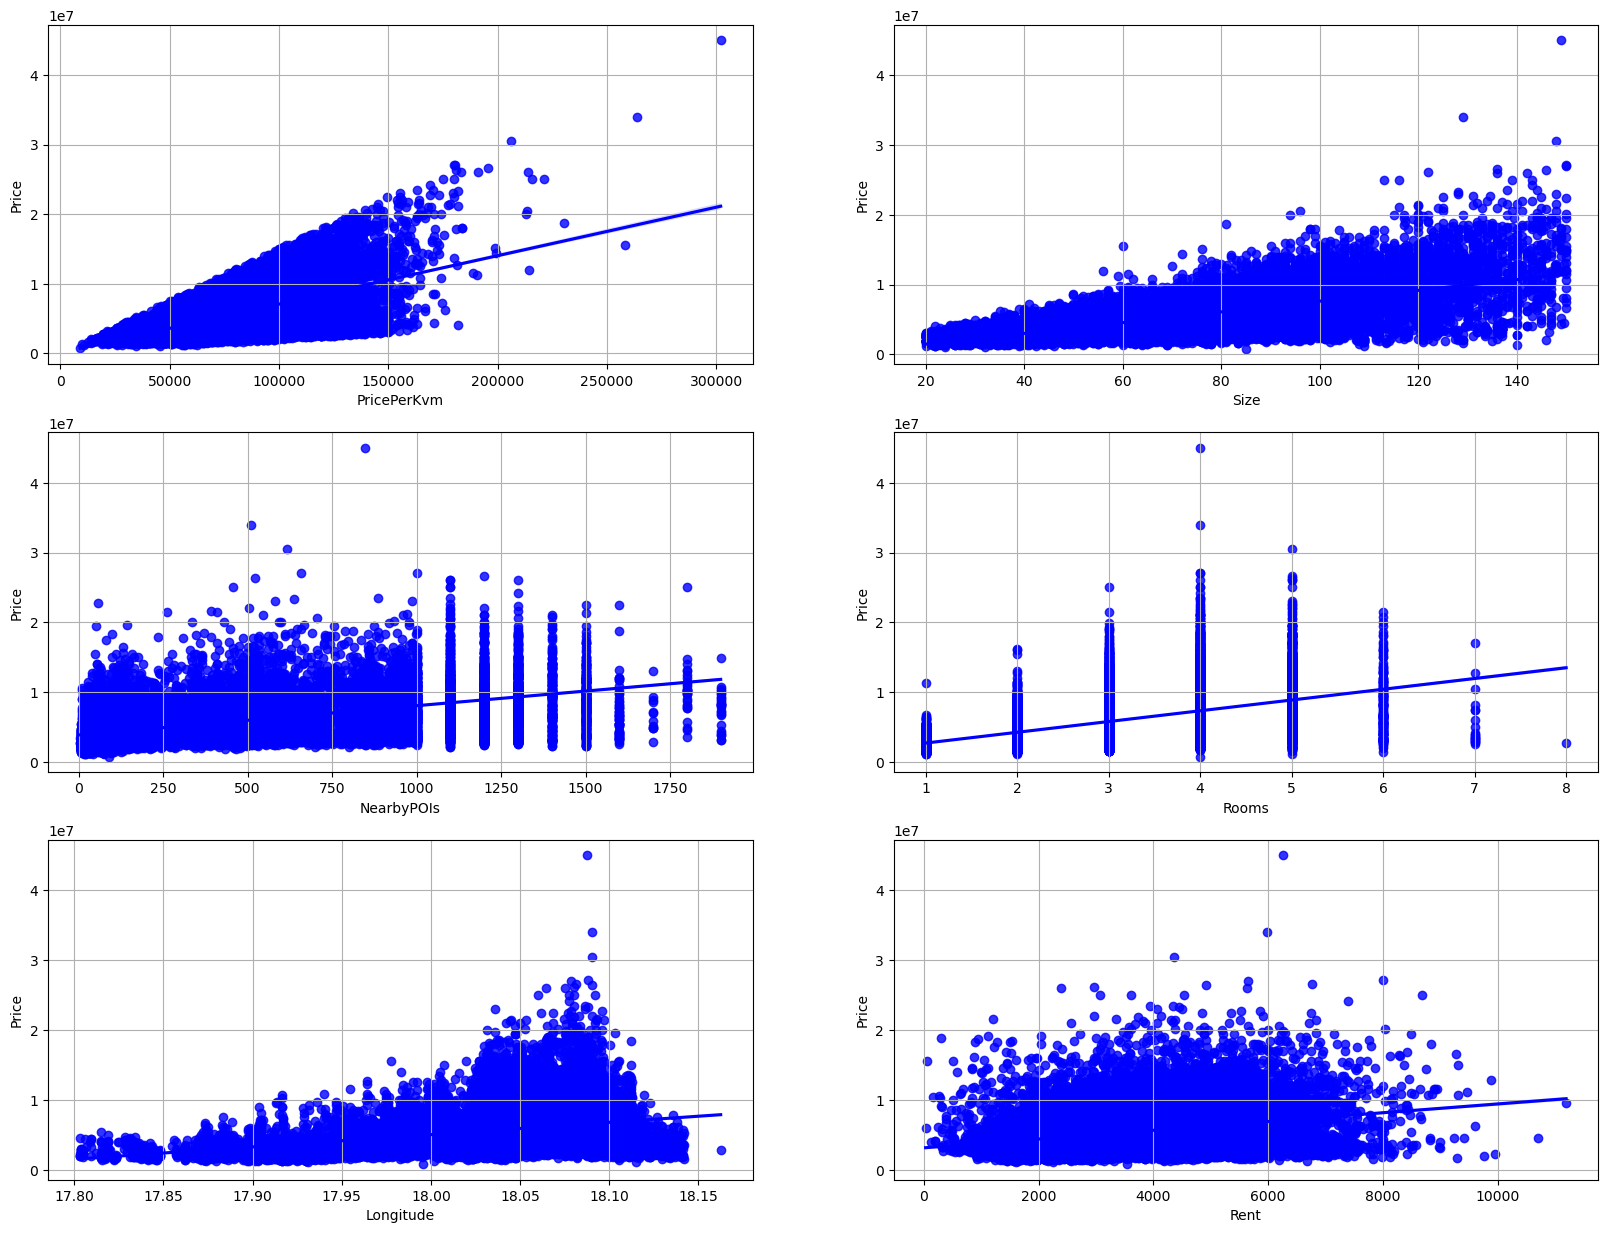

In [30]:
fig, ax1 = plt.subplots(3,2, figsize=(20,15))
k = 0
columns = ["PricePerKvm","Size","NearbyPOIs","Rooms","Longitude","Rent"]
for i in range(3):
    for j in range(2):
            sb.regplot(x=df[columns[k]],y=df["Price"],ax=ax1[i][j],color="blue")
            ax1[i][j].grid(True)
            k += 1
plt.show()

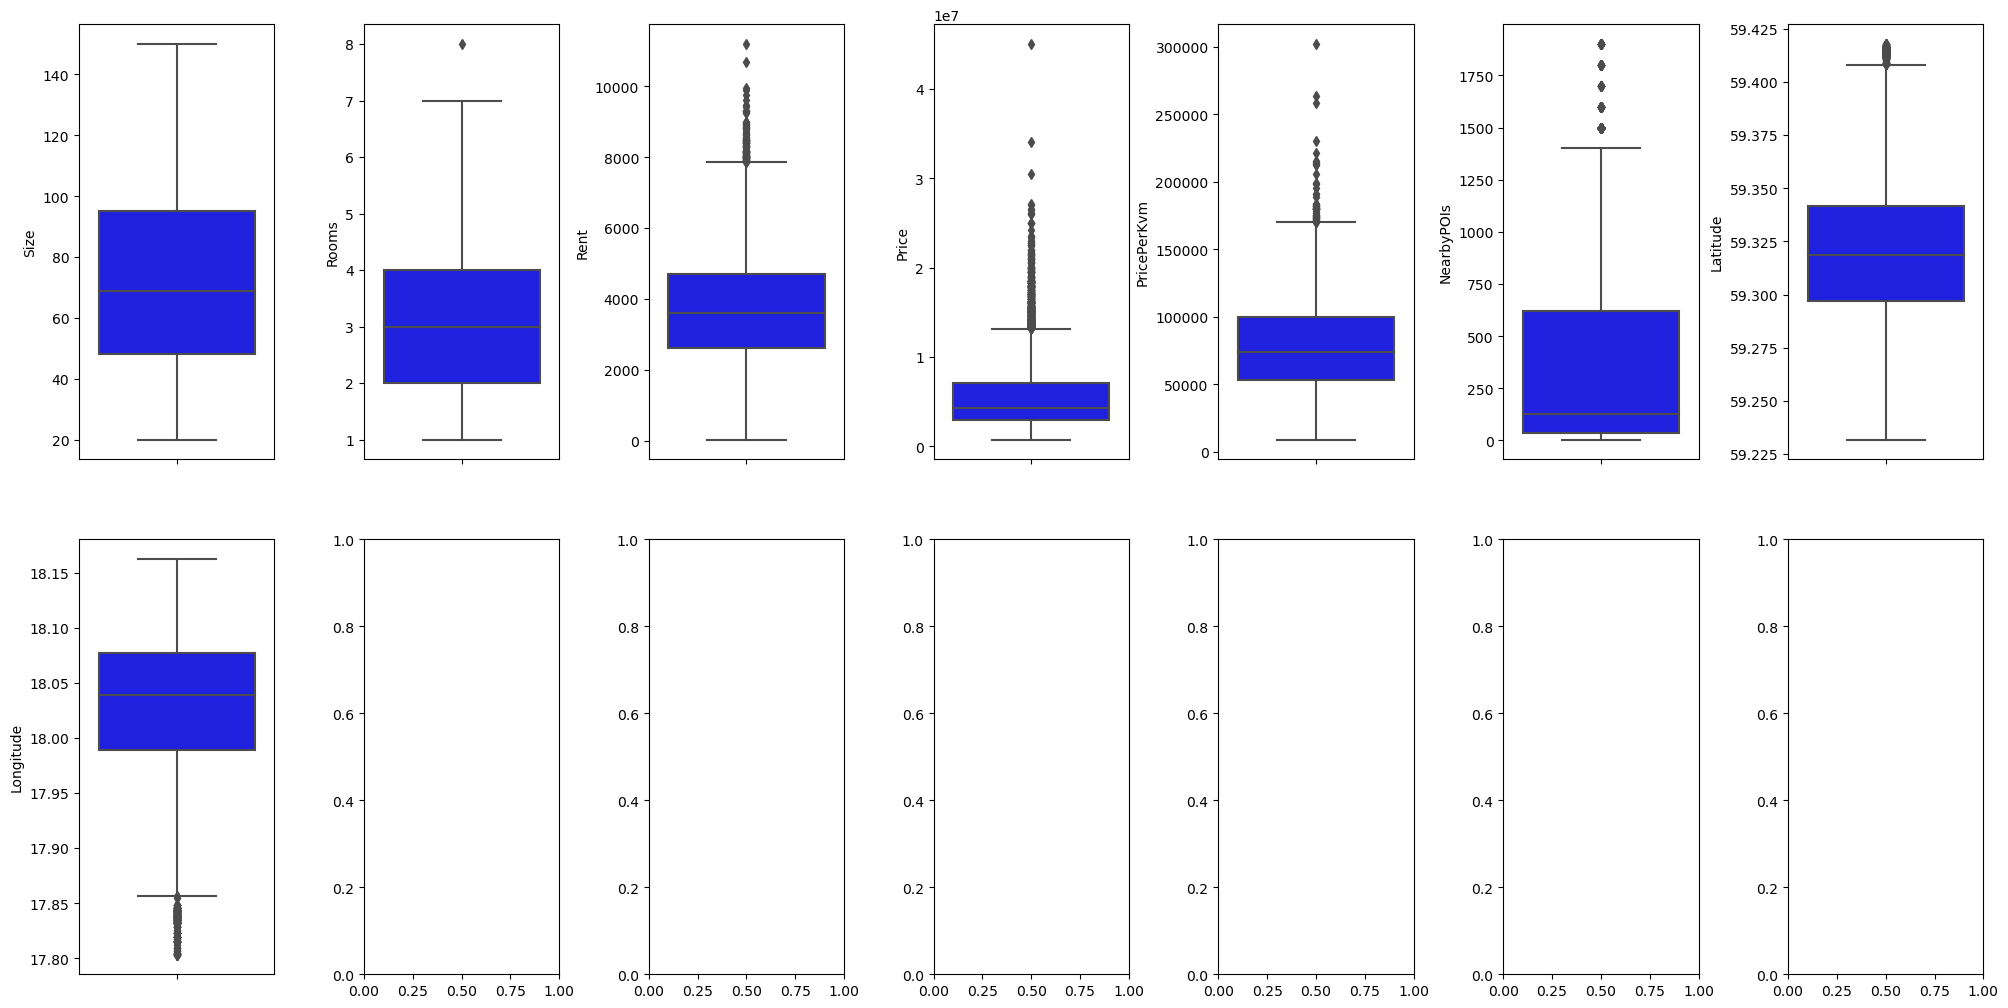

Column Size outliers = 0.00%
Column Rooms outliers = 0.13%
Column Rent outliers = 0.58%
Column Price outliers = 3.71%
Column PricePerKvm outliers = 0.32%
Column NearbyPOIs outliers = 2.37%
Column Latitude outliers = 1.66%
Column Longitude outliers = 1.89%


In [32]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in dist_df.items():
    sb.boxplot(y=k, data=dist_df, ax=axs[index],color="blue")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

for k, v in dist_df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(dist_df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

In [44]:
# Remove large outliers for Rent & Price that skew the data - Without this, the accuracy is around 2% lower
quant_rent = df['Rent'].quantile(0.8)
df = df[df['Rent'] < quant_rent]
df = df[df['Rent'] > 0]

quant_price = df['Price'].quantile(0.8)
df = df[df['Price'] < quant_price]
df = df[df['Price'] > 0]
features = ['Size', 'NearbyPOIs', 'Rooms', 'Longitude', 'Latitude']
target = 'Price'

# We can also use the standard scaler for removing the outliers

X = df[features]
Y = df[target]

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
######################
# PREDICTION MODEL - 1
######################

# Build prediction mode using XGBoost
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1477)

xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train,Y_train)

#Generate predicted values
Y_pred = xgbr.predict(X_test)

#Calculate and print the RMSE and the accuracy of our model.
mse=mean_squared_error(Y_test, Y_pred)
score=r2_score(Y_test,Y_pred)
print("Root Mean Square Error: %.2f" % (mse**(0.5)))
print("Accuracy: {} %".format(round((score*100),2)))

Root Mean Square Error: 471113.14
Accuracy: 89.39 %


In [46]:
# Fine tune hyperparameters
xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        random_state=50,
                        max_depth=6,
                        learning_rate = 0.08,
                        n_estimators = 500,
                        colsample_bylevel = 0.4,
                        reg_alpha = 1,
                        subsample = 1,
                       )

xgbr.fit(X_train,Y_train)
Y_pred = xgbr.predict(X_test)
mse=mean_squared_error(Y_test, Y_pred)
score=r2_score(Y_test,Y_pred)
print("Root Mean Square Error: %.2f" % (mse**(0.5)))
print("Accuracy: {} %".format(round((score*100),2)))

Root Mean Square Error: 461645.73
Accuracy: 89.81 %


In [47]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [6,10],
           'learning_rate': [0.01, 0.08],
           'colsample_bylevel': [0.3, 0.4],
         }

xgbr = xgb.XGBRegressor(seed=50)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, Y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(0.5))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'colsample_bylevel': 0.3, 'learning_rate': 0.08, 'max_depth': 10}
Lowest RMSE:  472281.2158216271


In [61]:
######################
# PREDICTION MODEL - 2
######################
# Build prediction mode using Random Forest Regression

rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', 
                           max_depth = 6, random_state = 1477)

rf.fit(X_train, Y_train)
prediction = rf.predict(X_test)

#Calculate and print the RMSE and the accuracy of our model.
mse=mean_squared_error(Y_test, Y_pred)    
score=r2_score(Y_test,Y_pred)
print("Root Mean Square Error: %.2f" % (mse**(0.5)))
print("Accuracy: {} %".format(round((score*100),2)))

Root Mean Square Error: 461645.73
Accuracy: 89.81 %


In [ ]:
# Evaluation of params - DON'T RUN without editing the max_leaf_nodes array ModelEvaluation.py to prevent computational hangover 
from ModelEvaluation import tryParameters
from VisualizeData import featureImportance, featuresCorrelation

# tryParameters(X_train, X_test, Y_train, Y_test)

# Test which features affect the prediction target the most
#featureImportance(trainedModel, trainFeatures, 7)
#featuresCorrelation(df, trainFeatures, trainPredictionTarget)